# EDA：逐分 momentum（方向/强度）建模动机与关键图

目标：验证发球优势的混杂性、展示比分/关键分导致的非平稳、可视化 match-level 的 rolling advantage（控制发球效应），并对反转前后候选触发因子做对齐分析。

In [3]:
# Imports and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set(style="darkgrid")
DATA_DIR = Path('2024C')
df = pd.read_csv('2024_Wimbledon_featured_matches.csv')
df['point_victor'] = df['point_victor'].astype(int)
# sanity
print('rows,cols:', df.shape)
df.head().T

rows,cols: (7284, 46)


,0,1,2,3,4
match_id,2023-wimbledon-1301,2023-wimbledon-1301,2023-wimbledon-1301,2023-wimbledon-1301,2023-wimbledon-1301
player1,Carlos Alcaraz,Carlos Alcaraz,Carlos Alcaraz,Carlos Alcaraz,Carlos Alcaraz
player2,Nicolas Jarry,Nicolas Jarry,Nicolas Jarry,Nicolas Jarry,Nicolas Jarry
elapsed_time,00:00:00,00:00:38,00:01:01,00:01:31,00:02:21
set_no,1,1,1,1,1
game_no,1,1,1,1,1
point_no,1,2,3,4,5
p1_sets,0,0,0,0,0
p2_sets,0,0,0,0,0
p1_games,0,0,0,0,0


发球方赢分率（按一/二发）:


C:\Users\DELL\AppData\Local\Temp\ipykernel_45540\1976499056.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pw = df.groupby(['server','serve_no']).apply(lambda g: (g['point_victor']==1).mean()).unstack(fill_value=np.nan)
C:\Users\DELL\AppData\Local\Temp\ipykernel_45540\1976499056.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  srv_by_serveno = df.groupby('serve_no').apply(lambda g: (g['point_victor']==g['serv

serve_no,1,2
server,,
1,0.765618,0.552672
2,0.256667,0.493546


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29699 (\N{CJK UNIFIED IDEOGRAPH-7403}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36194 (\N{CJK UNIFIED IDEOGRAPH-8D62}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2099

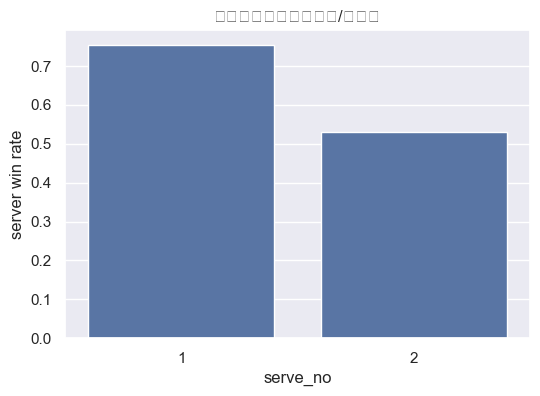

In [4]:
# 1) 发球优势：server 赢分率（整体 + 按一发/二发）
# compute p(player1 wins) conditional on (server, serve_no)
pw = df.groupby(['server','serve_no']).apply(lambda g: (g['point_victor']==1).mean()).unstack(fill_value=np.nan)
# compute server win rate (i.e., probability server wins the point) by serve_no
srv_by_serveno = df.groupby('serve_no').apply(lambda g: (g['point_victor']==g['server']).mean())
print('发球方赢分率（按一/二发）:')
display(pw)
plt.figure(figsize=(6,4))
sns.barplot(x=srv_by_serveno.index.astype(str), y=srv_by_serveno.values)
plt.xlabel('serve_no')
plt.ylabel('server win rate')
plt.title('发球方赢分率（按一发/二发）')
plt.show()

,condition,p1_win_rate,server_win_rate,n
0,break_point,0.500000,0.648810,504
1,no_break,0.511209,0.674926,6780


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30772 (\N{CJK UNIFIED IDEOGRAPH-7834}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 1998

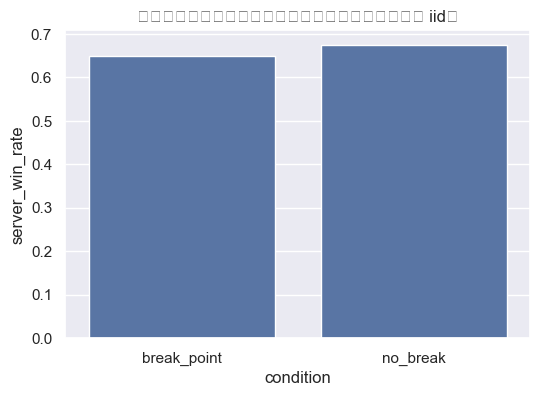

In [5]:
# 2) 关键分 / 比分压力：break point / deuce 条件下的赢分率差异
df['is_break'] = ((df['p1_break_pt']==1) | (df['p2_break_pt']==1)).astype(int)
conds = {'break_point': df['is_break']==1, 'no_break': df['is_break']==0}
rows = []
for name, cond in conds.items():
    sub = df[cond]
    rows.append((name, (sub['point_victor']==1).mean(), (sub['point_victor']==sub['server']).mean(), len(sub)))
summary = pd.DataFrame(rows, columns=['condition','p1_win_rate','server_win_rate','n'])
display(summary)
plt.figure(figsize=(6,4))
sns.barplot(x='condition', y='server_win_rate', data=summary)
plt.title('在破发点与非破发点时，发球方赢分率差异（说明非 iid）')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_45540\3569742042.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prob_table = df.groupby(['server','serve_no']).apply(lambda g: (g['point_victor']==1).mean()).rename('p1_win_prob').reset_index().set_index(['server','serve_no'])
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25511 (\N{CJK UNIFIED IDEOGRAPH-63A7}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21046 (\N{CJK UNIFIED IDEOGRAPH-5236}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io,

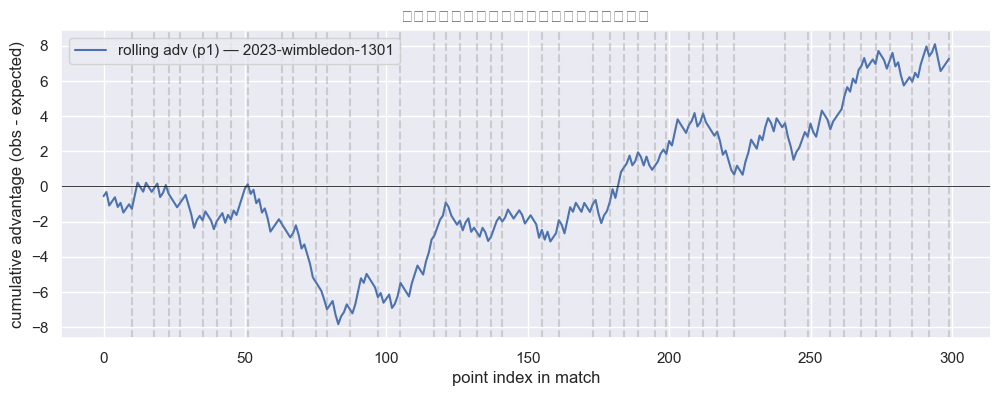

In [6]:
# 3) Swings 可视化：构造一个控制发球效应的 rolling advantage（player1 的瞬时优势）
prob_table = df.groupby(['server','serve_no']).apply(lambda g: (g['point_victor']==1).mean()).rename('p1_win_prob').reset_index().set_index(['server','serve_no'])
def expected_p1(row):
    try:
        return prob_table.loc[(row['server'], row['serve_no']), 'p1_win_prob']
    except Exception:
        return np.nan
df['exp_p1'] = df.apply(expected_p1, axis=1).fillna(df['point_victor'].map({1:1.0,2:0.0}).mean())
df['obs_p1'] = (df['point_victor']==1).astype(int)
df['adv_inc'] = df['obs_p1'] - df['exp_p1']
# pick a match to plot (first match_id)
mid = df['match_id'].unique()[0]
m = df[df['match_id']==mid].copy().reset_index(drop=True)
m['rolling_adv'] = m['adv_inc'].cumsum()
plt.figure(figsize=(12,4))
plt.plot(m['rolling_adv'].values, label=f'rolling adv (p1) — {mid}')
# mark game boundaries where game_no increments
game_changes = m.index[m['game_no'].diff().fillna(0)!=0].tolist()+[len(m)-1]
for b in game_changes:
    plt.axvline(b, color='gray', linestyle='--', alpha=0.3)
plt.axhline(0, color='k', linewidth=0.6)
plt.xlabel('point index in match')
plt.ylabel('cumulative advantage (obs - expected)')
plt.title('控制发球后：逐点累计优势曲线（示例比赛）')
plt.legend()
plt.show()

reversals detected: [np.int64(23), np.int64(52), np.int64(182)]


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21453 (\N{CJK UNIFIED IDEOGRAPH-53CD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36716 (\N{CJK UNIFIED IDEOGRAPH-8F6C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6528

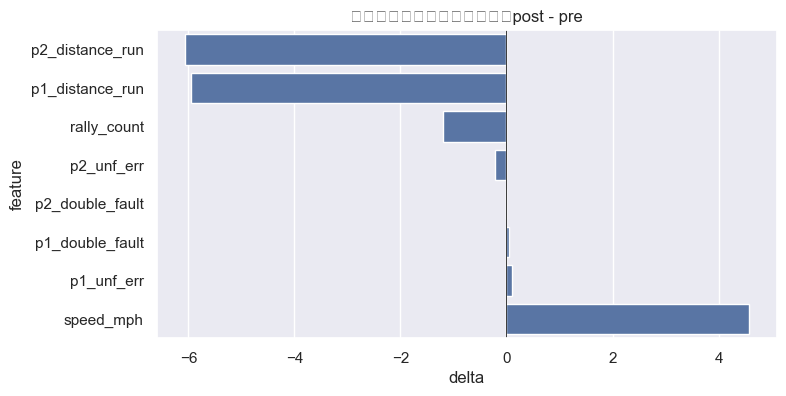

In [7]:
# 4) 反转（reversal）候选触发因子分析：对齐窗口比较前后特征均值
def find_reversals(series, min_sustain=4):
    signs = np.sign(series)
    changes = np.where(np.diff(signs)!=0)[0]+1
    revs = []
    for idx in changes:
        new_sign = signs[idx]
        if new_sign==0:
            continue
        end = idx+min_sustain
        if end < len(series) and np.all(np.sign(series[idx:end])==new_sign):
            revs.append(idx)
    return revs
revs = find_reversals(m['rolling_adv'].values, min_sustain=4)
print('reversals detected:', revs)
W=5
features = ['speed_mph','rally_count','p1_distance_run','p2_distance_run','p1_unf_err','p2_unf_err','p1_double_fault','p2_double_fault']
windows = []
for r in revs:
    pre = m.loc[max(0,r-W):r-1, features].astype(float).mean()
    post = m.loc[r:min(len(m)-1, r+W), features].astype(float).mean()
    tmp = pd.DataFrame({'feature':features, 'pre':pre.values, 'post':post.values})
    windows.append(tmp)
if len(windows)>0:
    agg = pd.concat(windows).groupby('feature').mean().reset_index()
    agg['delta'] = agg['post'] - agg['pre']
    plt.figure(figsize=(8,4))
    sns.barplot(x='delta', y='feature', data=agg.sort_values('delta'))
    plt.title('反转前后（平均）特征变化：post - pre')
    plt.axvline(0, color='k', linewidth=0.6)
    plt.show()
else:
    print('No reversals detected with current heuristic; try smaller min_sustain or inspect rolling_adv manually.')

**初步结论（供报告采纳与拓展）**:
- 发球方优势显著（尤其一发），若不在模型中显式控制，所谓的 momentum 可能只是发球轮换的反映。
- 在破发点/局末关键分处，赢分分布发生系统性变化，数据非 iid；需要动态模型或隐状态来解释持续性段（swings）。
- 使用“observed - expected（按 server/serve_no）”的累积和，可视化出比赛中的持续优势段并标注反转点，适合作为 flow 的基础指标。
- 对齐反转窗口（若能检测到足够数量反转），常见触发因子可能包括：发球速度下降/一发比例下降、回合数上升（更长相持）、非受迫失误或发球双误上升，提示疲劳或短期技术波动。
**下一步建议**：把上述 rolling advantage 纳入隐马尔可夫或带外生输入的状态空间模型（state = which side has momentum + intensity），并用跨赛例验证其稳定性；用事后可用特征（rally_count, UE, speed）解释反转。